got step 2: trying to help the "all" classifier by giving it cluster eta as a global feature.

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

data_path = '/fast_scratch/atlas_images/v01-45/'

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/Users/swiatlow/Code/ML4P/LCStudies')
sys.path.append('/home/mswiatlowski/start_tf/LCStudies')
import graph_util as gu
import plot_util as pu

path_pipm = data_path + 'pipm_medium.root'
path_pi0  = data_path + 'pi0_medium.root'


In [3]:
import convert_sets

Working on /fast_scratch/atlas_images/v01-45/pipm_medium.root
Loading data


KeyboardInterrupt: 

In [ ]:
pipm_med = np.load('/fast_scratch/atlas_images/v01-45/pipm_medium.npz')
pi0_med = np.load('/fast_scratch/atlas_images/v01-45/pi0_medium.npz')

In [ ]:
X_pipm = pipm_med['X']
X_pi0 = pi0_med['X']

Y_label_pipm = pipm_med['Y_label']
Y_label_pi0 = pi0_med['Y_label']

clus_eta_pipm = pipm_med['clus_eta']
clus_eta_pi0 = pi0_med['clus_eta']

In [ ]:
#cell X
X_all = np.concatenate((X_pipm[:39000], X_pi0[:39000])) #add one more zero once there's more space lol
Y_all = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm[:39000],Y_label_pi0[:39000])))

#global X

X_glob = np.concatenate((clus_eta_pipm[:39000], clus_eta_pi0[:39000]))

In [31]:
X = [X_all, X_glob]

In [32]:
X_all.shape, Y_all.shape, X_glob.shape

((78000, 2000, 4), (78000, 2), (78000,))

In [ ]:
def modelNmetrics(X_cell, X_glob, Y, batch_size, test_size):
    Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
    print('sizes: X ', len(X_cell), 'Y: ', len(Y))
    # do train/val/test split 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test, X_glob_tr, X_glob_val, X_glob_te) = data_split(X_cell, Y, X_glob, val=1000, test=test_size)
    print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
    
    #concatenate the Xs:
    X_tr = [X_train, X_glob_tr]
    X_vali = [X_val, X_glob_val]
    X_te = [X_test, X_glob_te]
    
    #make the model:
    pfn = PFN(input_dim=X_cell.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, num_global_features =1)
    
    #try callbacks:
    callback = tf.keras.callbacks.ModelCheckpoint('./w6_pfn1', save_best_only=True)
    
    # train model
    history = pfn.fit(X_tr, Y_train, epochs=100, batch_size=batch_size, validation_data=(X_vali, Y_val), verbose=1, callbacks=[callback])
    
    preds = pfn.predict(X_te, batch_size=1000)
    pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])
    # get area under the ROC curve
    auc = roc_auc_score(Y_test[:,1], preds[:,1])
    print('PFN AUC:', auc)
   
    return history, pfn_fp, pfn_tp, auc

In [34]:
history, pfn_fp, pfn_tp, auc = modelNmetrics(X_all, X_glob, Y_all, 1000, 9000)

sizes: X  78000 Y:  78000
(68000, 2000, 4) (1000, 2000, 4) (9000, 2000, 4) (68000, 2) (1000, 2) (9000, 2)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0] 

In [35]:
def plots(history, pfn_fp, pfn_tp, auc):
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[12,6])
    ax1.set_xlim(0,len(history.history['acc']))
    ax1.plot(history.history['acc'], label='training set', c='xkcd:butterscotch', linewidth=3)
    ax1.plot(history.history['val_acc'], label='test set', c='xkcd:coffee', linewidth=3)
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend()

    ax2.set_xlim(0,len(history.history['acc']))
    ax2.plot(history.history['loss'], label='training set', c='xkcd:dull brown', linewidth=3)
    ax2.plot(history.history['val_loss'], label='test set', c='xkcd:taupe', linewidth=3)
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.set_yscale('log')
    ax2.legend()
    
    plt.figure(figsize=[7,7])
    plt.xlim(-.01,1.01)
    plt.ylim(-.01,1.01)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(pfn_fp, pfn_tp, c='xkcd:dirt', linewidth=4, label='AUC = %.3f'%auc)
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.legend()

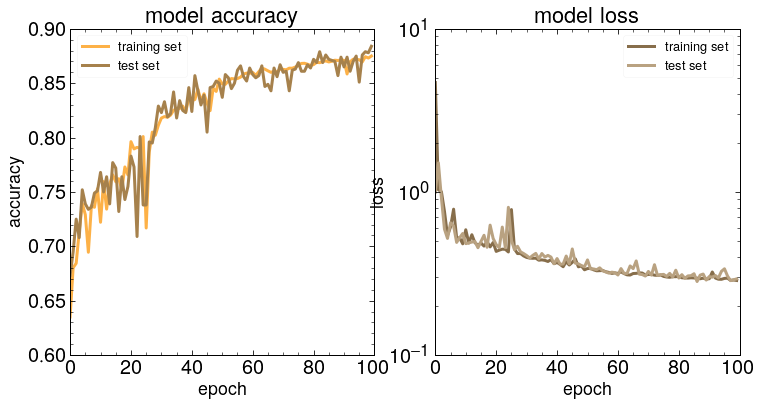

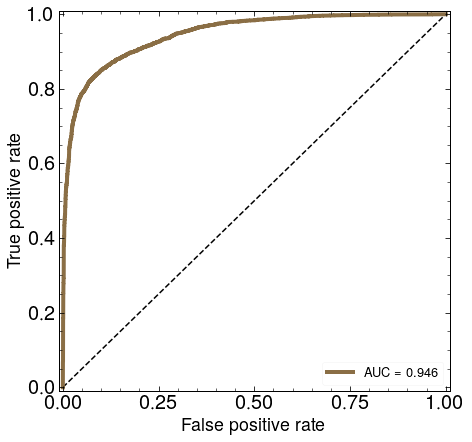

In [36]:
plots(history, pfn_fp, pfn_tp, auc)#with no cuts

In [37]:
#try with some cuts for best data, see if it has a good effect
selec_pipm = (abs(clus_eta_pipm) > 2.5) & (abs(clus_eta_pipm) < 3.1)
selec_pi0  = (abs(clus_eta_pi0) > 2.5) & (abs(clus_eta_pi0) < 3.1)


In [38]:
X_pipm_selec = X_pipm[selec_pipm]
X_pi0_selec = X_pi0[selec_pi0]

Y_label_pipm_selec = Y_label_pipm[selec_pipm]
Y_label_pi0_selec = Y_label_pi0[selec_pi0]

clus_eta_pipm_selec = clus_eta_pipm[selec_pipm]
clus_eta_pi0_selec = clus_eta_pi0[selec_pi0]

In [41]:
X = np.concatenate((X_pipm_selec[:36000], X_pi0_selec[:36000]))
Y = tf.keras.utils.to_categorical(np.concatenate((Y_label_pipm_selec[:36000],Y_label_pi0_selec[:36000])))
X_glob = np.concatenate((clus_eta_pipm[:36000], clus_eta_pi0[:36000]))

In [42]:
history_b2531, fp_b2531, tp_b2531, auc_b2531 = modelNmetrics(X, X_glob, Y, 1000, 9000)

sizes: X  72000 Y:  72000
(62000, 2000, 4) (1000, 2000, 4) (9000, 2000, 4) (62000, 2) (1000, 2) (9000, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0] 

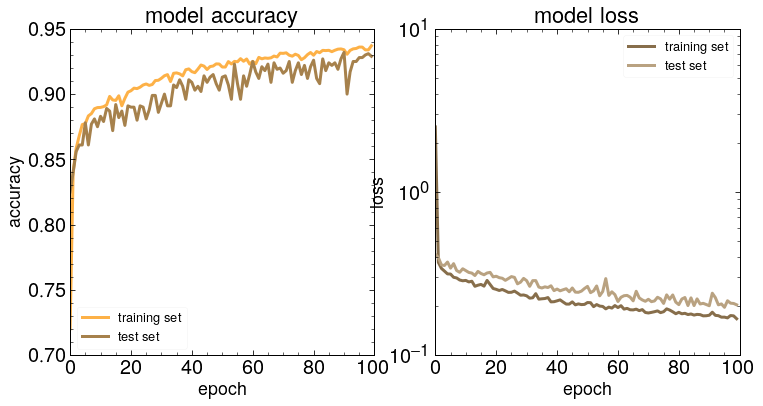

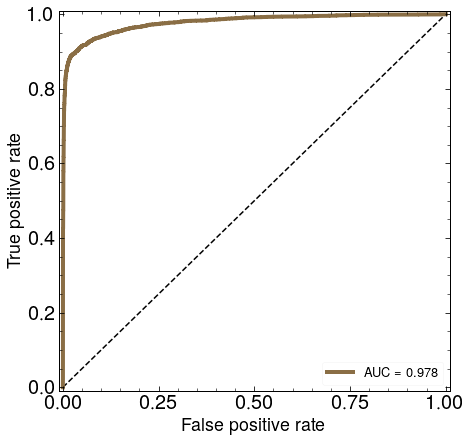

In [43]:
plots(history_b2531, fp_b2531, tp_b2531, auc_b2531)#with cuts, could keep going!